### Search Agent

In [1]:
# %%capture --no-stderr
# %pip install -U tavily-python
# %pip install -U langchain_community

In [1]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [3]:
_set_env("TAVILY_API_KEY")

In [4]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:") #saves it all in memory, you can change this to connect to your own DB or use a diff checkpointer

/Users/rickchakra/Projects/aiug_workshop/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# shared state for the graph containing messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# replacing manual tool node with prebuilt tool node
tool = TavilySearchResults(max_results=2)
tools= [tool]
llm = ChatOpenAI(model='gpt-3.5-turbo-0125')
llm_with_tools = llm.bind_tools(tools)

# call llm_with_tools with messages
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# add nodes to the graph
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# add edges to the graph
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")    

# compile graph with memory checkpointer
graph = graph_builder.compile(checkpointer=memory)

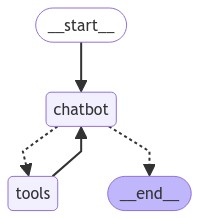

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
config = {"configurable": {"thread_id": "1"}}

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: I can help with a wide range of topics including answering questions, providing information, conducting searches, giving advice, and much more. Feel free to ask me anything you need assistance with!
Assistant: Great! Are you looking for information about a specific athletic event or are you interested in finding out about upcoming athletic events in general? Let me know so I can assist you accordingly.
Assistant: 
Assistant: [{"url": "https://runningintheusa.com/classic/list/new york-NY/upcoming/5k", "content": "15 Oct 5, 2024 Saturday Terry Fox Run for Cancer Research 5K - Central Park, NYC 5K run More Information New York, NY City Location details update save claim feature 16 Oct 12, 2024 Saturday Global Kids 5K 5K run | kids run More Information New York, NY City Location details update save claim feature 17 Oct 27, 2024 Sunday NYCRUNS Haunted ..."}, {"url": "https://www.active.com/new-york-ny/running/5k", "content": "Take on 

### prompt adjustment

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
# Get the prompt to use - you can modify this
from langchain import hub
prompt = hub.pull("hwchase17/react-chat")

In [ ]:
print(prompt.template)


In [ ]:
prompt.template = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist users to onboard onto a health and fitness platform. You must ask the users what wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

TOOLS:
------

Assistant has access to the following tools:

{tools}

To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
```

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: Do I need to use a tool? No
Final Answer: [your response here]
```

Begin!

Previous conversation history:
{chat_history}

New input: {input}
{agent_scratchpad}"""